## Pipeline 1: 
- ### learn the model comparison between a K and a Na channel model. 
- ### predict a model idx given observed data 
- ### learn the posterior over model parameters of the predicted model

In [1]:
import delfi.distribution as dd
import matplotlib as mpl
import numpy as np
import os
import pandas as pd
import pickle
import time

from delfi.generator import Default
from delfi.utils.viz import plot_pdf
from delfi.distribution.mixture import MoG

from lfimodels.channelomics.ChannelSingle import ChannelSingle
from lfimodels.channelomics.ChannelSuper import ChannelSuper
from lfimodels.channelomics.ChannelStats import ChannelStats
from matplotlib import pyplot as plt

import sys 
sys.path.append('../../')
from model_comparison.utils import *
from model_comparison.mdns import *

%matplotlib inline

## Set "k" or "na" as underlying ground truth model, generate observed data 

In [2]:
channel_type = 'k'

In [3]:
GT = {'k': np.array([9, 25, 0.02, 0.002]),
      'na': np.array([-35, 9, 0.182, 0.124, -50, -75, 5, -65, 6.2, 0.0091, 0.024])}

LP = {'k': ['qa','tha','Ra','Rb'],
      'na': ['tha','qa','Ra','Rb','thi1','thi2','qi','thinf','qinf','Rg','Rd']}

E_channel = {'k': -86.7, 'na': 50}
fact_inward = {'k': 1, 'na': -1}

gt = GT[channel_type]
cython = True
third_exp_model = True

n_params = len(gt)
labels_params = LP[channel_type]
prior_lims = np.sort(np.concatenate((0.5 * gt.reshape(-1,1), 1.5 * gt.reshape(-1,1)), axis=1))

In [4]:
m = ChannelSuper(channel_type=channel_type, third_exp_model=third_exp_model, cython=cython)
p = dd.Uniform(lower=prior_lims[:,0], upper=prior_lims[:,1])
s = ChannelStats(channel_type=channel_type)

In [5]:
# generate observed data
n_params_obs = len(gt)
m_obs = ChannelSingle(channel_type=channel_type, n_params=n_params_obs, cython=cython)

xo = m_obs.gen(gt.reshape(1, -1))
xo_stats = s.calc(xo[0])

/Users/janboelts/Documents/code/lfi-models/lfimodels/channelomics/ChannelStats.py:61: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  x, _, _, _ = np.linalg.lstsq(a, b)


## Load training data and split test data

In [6]:
filename = 'training_data_k_na_N10000seed3.p'
folder = '../data/'
fullpath = os.path.join(folder, filename)

with open(fullpath, 'rb') as f: 
    result_dict = pickle.load(f)

In [7]:
params_k, sx_k, gt_k, prior_lims_k, params_na, sx_na, gt_na, prior_lims_na, seed, n_samples, cython = result_dict.values()

ntest = 100
n, n_stats = sx_na.shape
ntrain = n - ntest

# shuffle and set up model index target vector 
sx = np.vstack((sx_k[:ntrain, :], sx_na[:ntrain, :]))
sx_test = np.vstack((sx_k[ntrain:, :], sx_na[ntrain:, :]))

# define model indices
m = np.hstack((np.zeros(ntrain), np.ones(ntrain))).squeeze().astype(int).tolist()
m_test = np.hstack((np.zeros(ntest), np.ones(ntest))).squeeze().astype(int).tolist()

# normalize data 
sx, data_norm = normalize(sx)

## Set up the NN and train it 

In [8]:
model_models = ClassificationMDN(n_input=n_stats, n_hidden_units=4, n_hidden_layers=1)
optimizer = torch.optim.Adam(model_models.parameters(), lr=0.01)
trainer = Trainer(model_models, optimizer, verbose=True, classification=True)

n_epochs = 10 
n_minibatch = int(ntrain / 100)

# train with training data
loss_trace = trainer.train(sx, m, n_epochs=n_epochs, n_minibatch=n_minibatch)

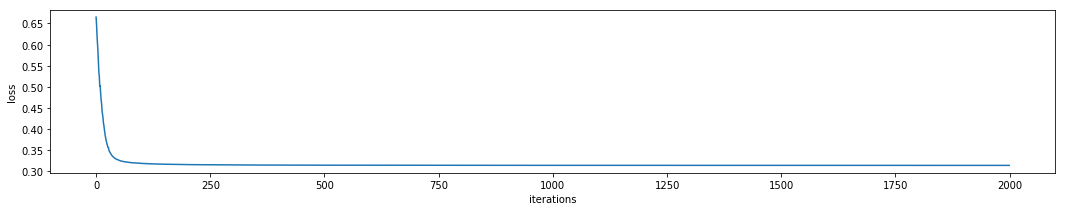

In [9]:
plt.figure(figsize=(18, 3))
plt.plot(loss_trace)
plt.ylabel('loss')
plt.xlabel('iterations');

## Predict underlying model given observed data

In [10]:
# predict 
# normalize using training data normalization 
sx_obs, data_norm = normalize(xo_stats, data_norm)

p_vec = model_models.predict(sx_obs)
print('True model: {}'.format(channel_type))
print('P(K | sx) = {:.2f}'.format(p_vec[0]))
print('P(Na | sx) = {:.2f}'.format(p_vec[1]))

True model: k
P(K | sx) = 1.00
P(Na | sx) = 0.00


## Predict test data and calculate test cross entropy loss

In [11]:
sx_test_zt, data_norm = normalize(sx_test, data_norm)
p = model_models.predict(sx_test_zt)[:, 1]
y = np.array(m_test)

In [12]:
cel = -(y * np.log(p) + (1 - y) * np.log(1 - p))
print('Cross entropy test loss: {:.4f}'.format(cel.sum()))

Cross entropy test loss: 0.0195


## Given the predicted underlying model we can learn the posterior of its parameters

In [13]:
predicted_model_idx = np.argmax(p_vec)
predicted_channel_type = ['k', 'na'][predicted_model_idx]
gt = GT[channel_type]
n_params_pred = len(gt)

# get corresponding data 
sx_pred = result_dict['sx_' + predicted_channel_type][:-1, ]
params_pred = result_dict['params_' + predicted_channel_type][:-1, ]

sx_test = result_dict['sx_' + predicted_channel_type][-1, ]
params_test = result_dict['params_' + predicted_channel_type][-1, ]

In [14]:
# define a network to approximate the posterior with a MoG 
model_params_mdn = MultivariateMogMDN(ndim_input=n_stats, ndim_output=n_params_pred, n_hidden_layers=2, 
                                      n_hidden_units=10, n_components=1)
optimizer = torch.optim.Adam(model_params_mdn.parameters(), lr=0.01)
trainer = Trainer(model_params_mdn, optimizer, verbose=True)

In [15]:
# normalize training data: predicted data only 
sx_normed, data_norm = normalize(sx_pred)

# normalize the parameters as well
params_ztrans, prior_norm = normalize(params_pred)

In [16]:
loss_trace = trainer.train(sx_normed, params_ztrans, n_epochs=200, n_minibatch=int(sx_pred.shape[0] / 100))

[epoch 0100] loss: -4.7341
[epoch 0200] loss: -5.6794


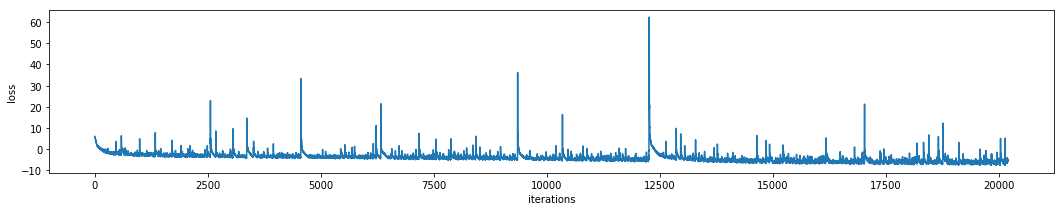

In [17]:
plt.figure(figsize=(18, 3))
plt.plot(loss_trace)
plt.ylabel('loss')
plt.xlabel('iterations');

In [32]:
# normalize the observed data with training norm 

sx_obs_zt, _ = normalize(xo_stats, data_norm)
params_obs = gt

In [33]:
# predict MoG parameters given observed data 
mog_posterior_pytorch = model_params_mdn.predict(sx_obs_zt.reshape(1, -1))

## Plot the learned MoG posterior using delfi distribution class

In [34]:
# define as delfi distribution
mog_posterior_delfi_zt = mog_posterior_pytorch.get_dd_object()

In [35]:
# transform back to prior ranges 
mog_posterior_delfi = mog_posterior_delfi_zt.ztrans_inv(mean=prior_norm[0], std=prior_norm[1])

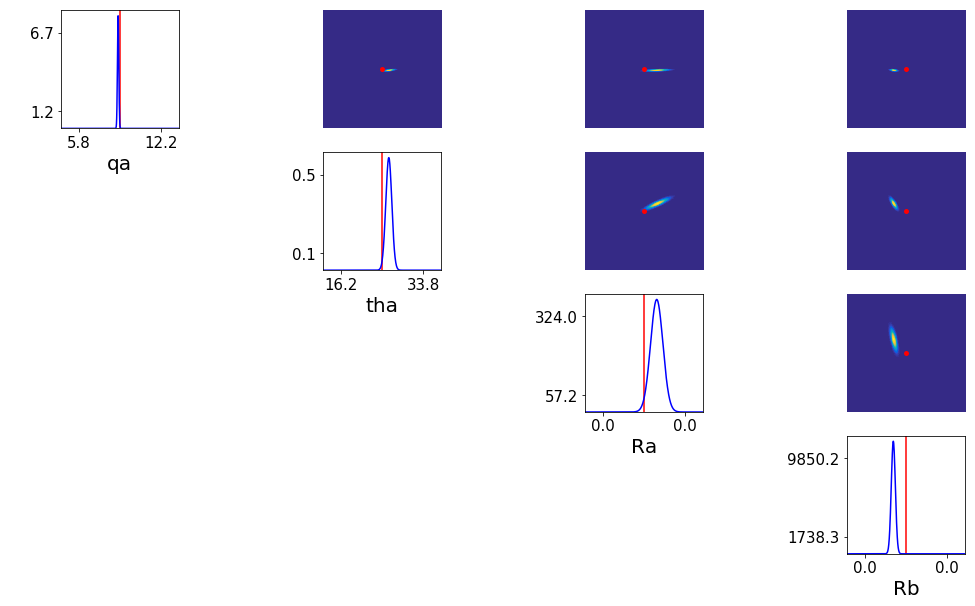

In [36]:
fig, ax = plot_pdf(mog_posterior_delfi, lims=prior_lims, figsize=(18, 10), ticks=True, 
                   labels_params=LP[predicted_channel_type], gt=params_obs)

In [37]:
mog_posterior_delfi.mean

array([8.86753711e+00, 2.64617786e+01, 2.21701408e-02, 1.78646510e-03])

In [38]:
params_obs

array([9.0e+00, 2.5e+01, 2.0e-02, 2.0e-03])

how to quantify the performance: 

sensitvity analysis? 

predictive checking? 

painfree estimate Macke, Wichmann 
coverage analysis 
Prangle paper, coverage property 

compare again SCM ABC, DIYABC, just sample a lot of data

it works on toy, why to do it? some real world examples

